In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

from tensorflow.python.keras.layers import Layer, Dense, LSTM, Dropout, LayerNormalization, Input
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.optimizer_v2 import adam
from keras.callbacks import EarlyStopping
from keras import backend as K
tf.__version__

'2.6.0'

In [ ]:
batch_size = 32
num_stocks = 31
seq_len = 5
num_features = 10
num_market_features = num_features

beta = 10.01
units = 64
ft_dim = 32
n_heads = 12

In [ ]:
def train_vaild_test_split(df):
    codes = df.code.unique()
    train_data = pd.DataFrame()
    vaild_data = pd.DataFrame()
    test_data = pd.DataFrame()
    for c in codes:
        df_stock = df[df.code == c]
        df_stock.reset_index(drop=True, inplace=True)
        times = sorted(df_stock.index.values)
        last_10pct = sorted(df_stock.index.values)[-int(0.01*len(times))] # Last 1% of series
        last_20pct = sorted(df_stock.index.values)[-int(0.02*len(times))] # Last 2% of series
        
        df_train = df_stock[(df_stock.index < last_20pct)]  # Training data are 80% of total data
        df_val = df_stock[(df_stock.index >= last_20pct) & (df_stock.index < last_10pct)]
        df_test = df_stock[(df_stock.index >= last_10pct)]
        stock_test_data_date[df_test.code.unique()[0]] = list(df_test.date)
        train_data = pd.concat([train_data, df_train])
        vaild_data = pd.concat([vaild_data, df_val])
        test_data = pd.concat([test_data, df_test])
    return train_data, vaild_data, test_data

In [ ]:
stock_test_data_date = {} # key = 종목명,  value = [해당 종목 테스트 일자]
kospi31 = pd.read_csv("preprocessed_kospi31_daily_stock_chart.csv")
market_index = kospi31[kospi31.code == "U182"]
stocks = kospi31[kospi31.code != "U182"]
market_train_data, market_vaild_data, market_test_data = train_vaild_test_split(market_index)
stock_train_data, stock_vaild_data, stock_test_data = train_vaild_test_split(stocks)
print(market_train_data.shape, market_vaild_data.shape, market_test_data.shape)
print(stock_train_data.shape, stock_vaild_data.shape, stock_test_data.shape)

(4538, 13) (46, 13) (46, 13)
(140678, 13) (1426, 13) (1426, 13)


In [ ]:
from tensorflow.python.keras.layers import Layer, Dense, LSTM, MultiHeadAttention, LayerNormalization, Dropout, Input
from tensorflow.python.keras.models import Model

class FeatureTransformation(Layer):
    """
    Input: (None, stock, time, feature), (None, 1, time, feature)
    Output: (None, stock, time, ft_dim), (None, 1, time, ft_dim)
    """
    def __init__(self, ft_dim, **kwargs):
        super(FeatureTransformation, self).__init__()
        self.ft_dim = ft_dim

    def build(self, input_shape,  **kwargs):
        shape = input_shape[0][1:]
        self.ft_linear = Dense(self.ft_dim,
                               input_shape=shape,
                               kernel_initializer='glorot_uniform',
                               bias_initializer='glorot_uniform',
                               activation='tanh')

    def call(self, inputs, *args, **kwargs):
        stock, market = inputs[0], inputs[1]
        stock = self.ft_linear(stock)
        market = self.ft_linear(market)
        return stock, market

    def get_config(self):
        config = super(FeatureTransformation, self).get_config().copy()
        config.update({'ft_dim':self.ft_dim})
        return config

class AttentionLSTM(Layer):
    """
    Input: (None, time, ft_dim)
    Output: (None, time, units)
    """
    def __init__(self, units, **kwargs):
        super(AttentionLSTM, self).__init__()
        self.units = units

    def build(self, input_shape,  **kwargs):
        self.lstm = LSTM(self.units, return_sequences=True, return_state=False)

    def call(self, inputs, *args, **kwargs):
        feature = self.lstm(inputs)
        attn_score = tf.matmul(feature, feature[:, -1:, :], transpose_b=True)
        feature = attn_score * feature
        return feature

    def get_config(self):
        config = super(AttentionLSTM, self).get_config().copy()
        config.update({'units':self.units})
        return config

class ContextNormalize(Layer):
    """
    Input: (None, time, units)
    Output: (None, time, units)
    """
    def __init__(self, **kwargs):
        super(ContextNormalize, self).__init__()

    def build(self, input_shape,  **kwargs):
        shape = input_shape[1:]
        self.norm_weight = self.add_weight(name='norm_weight',
                                           shape=shape,
                                           initializer='uniform',
                                           trainable=True)

        self.norm_bias = self.add_weight(name='norm_bias',
                                         shape=shape,
                                         initializer='uniform',
                                         trainable=True)

    def call(self, inputs, *args, **kwargs):
        context = (inputs - tf.math.reduce_mean(inputs))/tf.math.reduce_std(inputs)
        context = self.norm_weight*context + self.norm_bias
        return context

    def get_config(self):
        config = super(ContextNormalize, self).get_config().copy()
        return config

class MultiAttentionLSTM(Layer):
    """
    Input: (None, num_stocks, time, ft_dim)
    Output: (None, time, units) * num_stocks
    """
    def __init__(self, units, num_stocks, **kwargs):
        super(MultiAttentionLSTM, self).__init__()
        self.units = units
        self.num_stocks = num_stocks

    def build(self, input_shape):
        self.attn_lstm = [AttentionLSTM(self.units) for _ in range(self.num_stocks)]
        self.context_norm = [ContextNormalize() for _ in range(self.num_stocks)]

    def call(self, inputs, *args, **kwargs):
        attn_weights = [self.attn_lstm[i](inputs[:, i, :, :]) for i in range(self.num_stocks)]
        attn_weights = [self.context_norm[i](attn_weights[i]) for i in range(self.num_stocks)]
        attn_weights = [tf.expand_dims(x, axis=1) for x in attn_weights]
        attn_weights = tf.concat(attn_weights, axis=1)
        return attn_weights

    def get_config(self):
        config = super(MultiAttentionLSTM, self).get_config().copy()
        config.update({'units': self.units,
                       'num_stocks':self.num_stocks})
        return config


class MultiLevelAggregator(Layer):
    """
    Input: (None, num_stocks, time, units), (None, 1, time, units)
    Output: (None, time, units)
    """
    def __init__(self, beta, **kwargs):
        super(MultiLevelAggregator, self).__init__()
        self.beta = beta

    def call(self, inputs, *args, **kwargs):
        context_stock, context_market = inputs[0], inputs[1]
        context = context_stock + self.beta*context_market
        context = tf.math.reduce_sum(context, axis=2)
        return context

    def get_config(self):
        config = super(MultiLevelAggregator, self).get_config().copy()
        config.update({'beta':self.beta})
        return config

class DataStack(Layer):
    """
    Input: (None, time, units) * num_stocks
    Output: (None, num_stocks, units)
    """
    def __init__(self, **kwargs):
        super(DataStack, self).__init__()

    def call(self, inputs, *args):
        inputs = [tf.expand_dims(x, axis=1) for x in inputs]
        inputs = tf.concat(inputs, axis=1)
        context = tf.math.reduce_sum(inputs, axis=2)
        return context

class NonlinearPrediction(Layer):
    """
    Input: (None, num_stocks, units)
    Output: (None, num_stocks, 1)
    """
    def __init__(self, **kwargs):
        super(NonlinearPrediction, self).__init__()

    def build(self, input_shape,  **kwargs):
        hidden_size = input_shape[0][-1]
        self.mlp_linear1 = Dense(4*hidden_size,
                                 input_shape=input_shape,
                                 kernel_initializer='glorot_uniform',
                                 bias_initializer='glorot_uniform',
                                 activation='relu')

        self.mlp_linear2 = Dense(hidden_size,
                                 kernel_initializer='glorot_uniform',
                                 bias_initializer='glorot_uniform',
                                 activation='relu')

        self.mlp_dropout = Dropout(0.15)
        self.mlp_norm = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

        self.pred_linear = Dense(1, activation='sigmoid',
                                 kernel_regularizer='l2', bias_regularizer='l2')

    def call(self, inputs, *args):
        context, attn_weight = inputs[0], inputs[1]
        residual_context = context + attn_weight

        mlp_weight = self.mlp_linear1(residual_context)
        mlp_weight = self.mlp_linear2(mlp_weight)

        residual_context = tf.nn.tanh(residual_context + mlp_weight)
        residual_context = self.mlp_dropout(residual_context)
        residual_context = self.mlp_norm(residual_context)

        output = self.pred_linear(residual_context)
        return output

In [ ]:

def custom_loss(y_true, y_pred):
  y_pred = tf.convert_to_tensor(y_pred)
  y_true = tf.cast(y_true, y_pred.dtype)
  
  return -tf.reduce_mean(tf.math.multiply(y_true * tf.math.log(y_pred) , 1.03) + (1 - y_true) * tf.math.log(1 - y_pred))

In [ ]:
from keras import backend as K
def mcc(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))

    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    return num / K.sqrt(den + K.epsilon())

def create_model(n=num_stocks):
    num_stocks = n
    feature_transformation = FeatureTransformation(ft_dim)
    multi_attn_lstm1 = MultiAttentionLSTM(units, num_stocks)
    multi_attn_lstm2 = MultiAttentionLSTM(units, 1)
    multi_lvl_aggregator = MultiLevelAggregator(beta)
    attention = MultiHeadAttention(num_heads=n_heads, key_dim=128, value_dim=128,
                                   dropout=0.15)
    attn_norm = LayerNormalization(epsilon=1e-6)
    nonlinear_pred = NonlinearPrediction()

    stock_inputs = Input(shape=(num_stocks, seq_len, num_features))
    market_inputs = Input(shape=(1, seq_len, num_market_features))

    feature_stock, feature_market = feature_transformation([stock_inputs, market_inputs])
    context_stock = multi_attn_lstm1(feature_stock)
    context_market = multi_attn_lstm2(feature_market)

    context = multi_lvl_aggregator([context_stock, context_market])

    attn_weight = attention(context, context)
    attn_weight = attn_norm(attn_weight)
    output = nonlinear_pred([context, attn_weight])
    
    model = Model(inputs=[stock_inputs, market_inputs], outputs=output)
    model.compile(loss=tf.losses.binary_crossentropy, optimizer='adam', metrics=['accuracy', mcc])

    return model

In [ ]:
def market_stock_split(df):
    market_df = df[df.code=='U182']
    stock_df = df[df.code!='U182']
    return market_df, stock_df

def stock_seperate(stocks):
    stock_names = stocks['name'].unique()
    res = []
    for stock in stock_names:
        res.append(stocks[stocks.name==stock])
    return res

def train_test_split(stocks_df, test_pct=0.2, valid_pct=0.2):
    if not isinstance(stocks_df, (list, tuple)):
        return train_test_split([stocks_df], test_pct, valid_pct)

    stocks_train, stocks_valid, stocks_test = [],[],[]
    for stock in stocks_df:
        test_size = int(len(stock)*test_pct)
        valid_size = int(len(stock)*valid_pct)
        train_size = len(stock) - test_size - valid_size

        stocks_train.append(stock[:train_size])
        stocks_valid.append(stock[train_size:train_size+valid_size])
        stocks_test.append(stock[-test_size:])

    return stocks_train, stocks_valid, stocks_test

def input_target_split(stocks_df):
    target = [stock['close'].apply(lambda x: int(x>0)) for stock in stocks_df]
    return stocks_df, target

def window_split(inputs, targets, window_size=10):
    inputs = inputs.values
    targets = targets.values
    X = []
    y = []
    for i in range(window_size, len(inputs)):
        X.append(inputs[i-window_size:i])
        y.append(targets[i])

    return np.array(X), np.array(y)

def stocks_window_split(stocks_inputs, stocks_target, window_size=10):
    X,y = [],[]
    for j in range(window_size, len(stocks_inputs[0])):
        bucket_X = []
        bucket_y = []
        for i in range(len(stocks_inputs)):
            stock = stocks_inputs[i].values
            target = stocks_target[i].values
            bucket_X.append(stock[j-window_size:j])
            bucket_y.append(target[j])
        X.append(bucket_X)
        y.append(bucket_y)
    return np.array(X), np.array(y)

def prepare_data(path, **kwargs):
    df = pd.read_csv(path)
    market, stocks = market_stock_split(df)
    stocks = stock_seperate(stocks)
    print(len(stocks))
    for i in range(len(stocks)):
        stocks[i].drop(['code','name', 'date'], axis=1, inplace=True)
    market.drop(['code','name', 'date'], axis=1, inplace=True)

    market_train_valid_test = train_test_split(market,
                                               test_pct=kwargs.get('test_pct'),
                                               valid_pct=kwargs.get('valid_pct')) # [m_train], [m_valid], [m_test]
    stock_train_valid_test = train_test_split(stocks,
                                              test_pct=kwargs.get('test_pct'),
                                              valid_pct=kwargs.get('valid_pct')) # [s_train1, ...], [s_valid1, ...], [s_test1, ...]

    print(f'market_train_valid_test: {len(market_train_valid_test)}')
    print(f'market_train_valid_test[0]: {len(market_train_valid_test[0])}')

    print(f'stock_train_valid_test: {len(stock_train_valid_test)}')
    print(f'stock_train_valid_test[0]: {len(stock_train_valid_test[0])}')
    print(f'stock_train_valid_test[0][0]: {stock_train_valid_test[0][0].shape}')

    market_data = [input_target_split(m) for m in market_train_valid_test] # [([m_train_X], [m_train_y]), (...), (...)]
    stock_data = [input_target_split(s) for s in stock_train_valid_test] # [([s_train1_X, ...], [s_train1_y, ...]), (...), (...)]

    print(f'market_data: {len(market_data)}')
    print(f'market_data[0]: {len(market_data[0])}')
    print(f'market_data[0][0]: {len(market_data[0][0])}')
    print(f'market_data[0][0][0]: {market_data[0][0][0].shape}')

    print(f'stock_data: {len(stock_data)}')
    print(f'stock_data[0]: {len(stock_data[0])}')
    print(f'stock_data[0][0]: {len(stock_data[0][0])}')
    print(f'stock_data[0][0][0]: {stock_data[0][0][0].shape}')

    window_size = kwargs['window_size']
    market_data = [stocks_window_split(*m, window_size) for m in market_data]
    stock_data = [stocks_window_split(*s, window_size) for s in stock_data]
    return market_data, stock_data

In [ ]:

import os
path = os.path.abspath('preprocessed_kospi31_daily_stock_chart.csv')
option = {
    'window_size':seq_len,
    'test_pct':0.01,
    'valid_pct':0.01
}
market_data, stock_data = prepare_data(path, **option)
(X_train_m, y_train_m), (X_valid_m, y_valid_m), (X_test_m, y_test_m) = market_data
(X_train_s, y_train_s), (X_valid_s, y_valid_s), (X_test_s, y_test_s) = stock_data

31
market_train_valid_test: 3
market_train_valid_test[0]: 1
stock_train_valid_test: 3
stock_train_valid_test[0]: 31
stock_train_valid_test[0][0]: (4538, 10)
market_data: 3
market_data[0]: 2
market_data[0][0]: 1
market_data[0][0][0]: (4538, 10)
stock_data: 3
stock_data[0]: 2
stock_data[0][0]: 31
stock_data[0][0][0]: (4538, 10)


In [ ]:
print(X_train_m.shape, y_train_m.shape)

(4533, 1, 5, 10) (4533, 1)


In [ ]:
def get_acc(y_true, y_pred):
    cnt = []
    for t, p in zip(np.ravel(y_true), np.ravel(y_pred)):
        if t == 0 and p == 0:
            cnt.append(1)
        elif t > 0 and p > 0.5:
            cnt.append(1)
        elif t < 0 and p < 0.5:
            cnt.append(1)
        else:
            cnt.append(0)
    cnt = tf.convert_to_tensor(cnt, dtype=tf.float32)
    return tf.reduce_mean(cnt)


def acc(y_true, y_pred):
    score = tf.py_function(func=get_acc, inp=[y_true, y_pred], Tout=tf.float32)
    return score

In [ ]:
# def get_mcc(y_true, y_pred)

def mcc(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))

    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    return num / K.sqrt(den + K.epsilon())


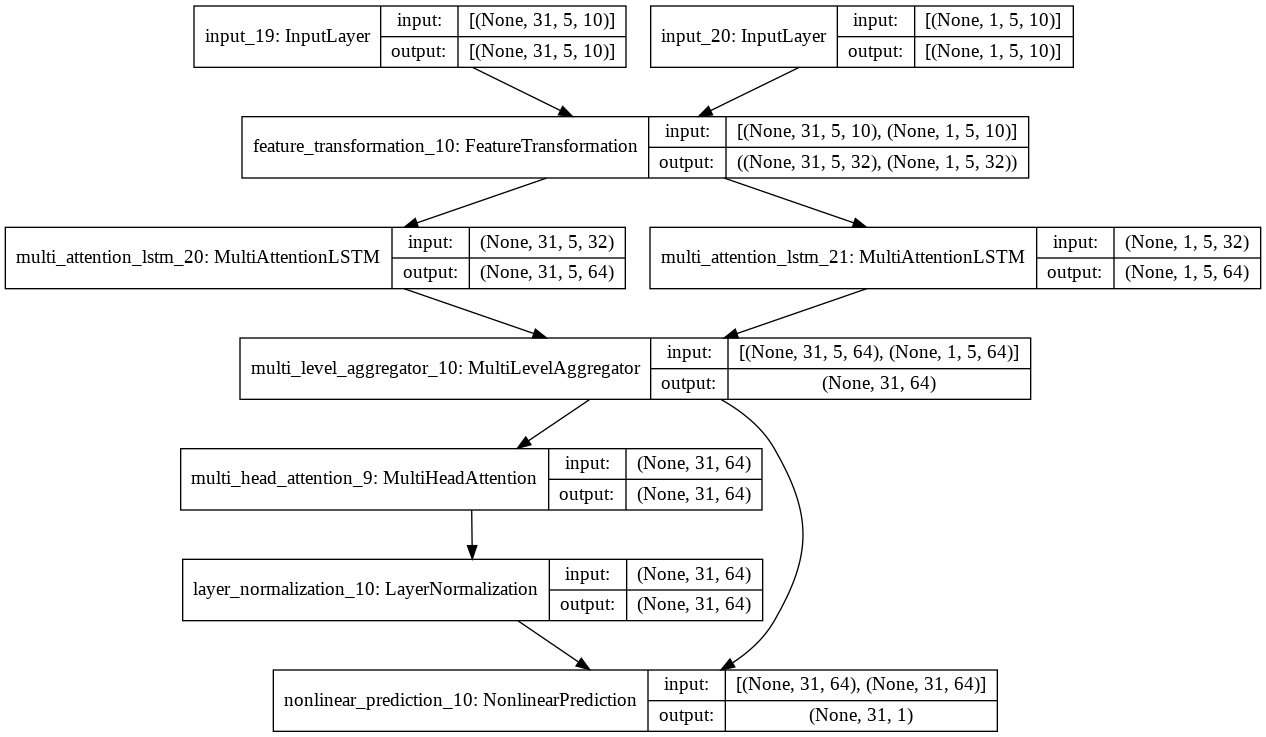

In [ ]:
from tensorflow.python.keras.utils.vis_utils import plot_model
model = create_model()
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 31, 5, 10)]  0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 1, 5, 10)]   0                                            
__________________________________________________________________________________________________
feature_transformation_10 (Feat ((None, 31, 5, 32),  352         input_19[0][0]                   
                                                                 input_20[0][0]                   
__________________________________________________________________________________________________
multi_attention_lstm_20 (MultiA (None, 31, 5, 64)    789632      feature_transformation_10[0

In [ ]:
# callback = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/programmers/project/model/DTML.hdf5',
#                                               monitor='val_loss',
#                                               save_best_only=True, 
#                                               verbose=1)
mc =  tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/programmers/project/model/DTML3.hdf5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)



history = model.fit([X_train_s, X_train_m], y_train_s,
                    batch_size=batch_size,
                    epochs=100,
                    # callbacks=es,
                    callbacks=[mc, es],
                    validation_data=([X_valid_s, X_valid_m], y_valid_s)
)
model.save('DTML_custom_loss_sequence_5')

Epoch 1/100
142/142 [==============================] - 184s 754ms/step - loss: 0.7860 - accuracy: 0.5059 - mcc: 0.0042 - val_loss: 0.7067 - val_accuracy: 0.5437 - val_mcc: 0.0000e+00

Epoch 00001: val_accuracy improved from -inf to 0.54367, saving model to /content/drive/MyDrive/programmers/project/model/DTML3.hdf5
Epoch 2/100
142/142 [==============================] - 101s 714ms/step - loss: 0.7364 - accuracy: 0.5039 - mcc: -0.0022 - val_loss: 0.7031 - val_accuracy: 0.5452 - val_mcc: 0.0239

Epoch 00002: val_accuracy improved from 0.54367 to 0.54524, saving model to /content/drive/MyDrive/programmers/project/model/DTML3.hdf5
Epoch 3/100
142/142 [==============================] - 100s 705ms/step - loss: 0.7269 - accuracy: 0.5053 - mcc: 4.2171e-04 - val_loss: 0.7000 - val_accuracy: 0.5437 - val_mcc: 0.0000e+00

Epoch 00003: val_accuracy did not improve from 0.54524
Epoch 4/100
142/142 [==============================] - 100s 707ms/step - loss: 0.7173 - accuracy: 0.5081 - mcc: 0.0021 - va

INFO:tensorflow:Assets written to: DTML_custom_loss_sequence_5/assets


INFO:tensorflow:Assets written to: DTML_custom_loss_sequence_5/assets


In [ ]:

train_pred = model.predict((X_train_s, X_train_m))
val_pred = model.predict((X_valid_s, X_valid_m))
test_pred = model.predict((X_test_s, X_test_m))

# #Print evaluation metrics for all datasets
train_eval = model.evaluate((X_train_s, X_train_m), y_train_m, verbose=0)
val_eval = model.evaluate((X_valid_s, X_valid_m), y_valid_m, verbose=0)
test_eval = model.evaluate((X_test_s, X_test_m), y_test_m, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, ACC: {:.4f}, MCC: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, ACC: {:.4f}, MCC: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, ACC: {:.4f}, MCC: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

 
Evaluation metrics
Training Data - Loss: 0.6962, ACC: 0.5110, MCC: 0.0647
Validation Data - Loss: 0.7092, ACC: 0.4618, MCC: 0.0164
Test Data - Loss: 0.7049, ACC: 0.5161, MCC: 0.0452


In [ ]:
import keras
model2 = keras.models.load_model('DTML_custom_loss', custom_objects={
    'FeatureTransformation': FeatureTransformation, 
    'AttentionLSTM': AttentionLSTM,
    'ContextNormalize': ContextNormalize,
    'MultiAttentionLSTM': MultiAttentionLSTM,
    'MultiLevelAggregator': MultiLevelAggregator,
    'DataStack': DataStack,
    'NonlinearPrediction': NonlinearPrediction
})

## Back Testing

In [ ]:
import matplotlib.pyplot as plt
import datetime as dt
stock_raw_data = pd.read_csv('kospi31-2003-2021.csv')
seed = 10000000 
threshold_prob = 0.54
result1 = dict.fromkeys(list(stock_raw_data['code']))
del result1['U182'] 
for idx, key in enumerate(result1.keys()):
  result1[key] = idx 
idx_to_name = {}
for k, v in result1.items():
  idx_to_name[v] = k 
first_seed = seed
my_seed = [first_seed]
buy_date_for_x = [dt.datetime.strptime(str(stock_test_data_date['삼성전자'][0]) , "%Y%m%d") - dt.timedelta(days=1)]
for test_day_idx, day_predict in enumerate(test_pred):
  max_idx = -1 
  max_prob = 0
  for stock_idx, predict in enumerate(list(day_predict)):
    if predict[0] > max_prob:
      max_idx = stock_idx 
      max_prob = predict[0] 
    
  # 확률이 50% 이상이면(추후에 더 높게 조정 가능)
  if max_prob > threshold_prob:
    buy_stock_name = idx_to_name[max_idx]
    buy_stock_day  = stock_test_data_date[buy_stock_name][test_day_idx] 
    
    open = float(stock_raw_data[(stock_raw_data['code'] == buy_stock_name) & (stock_raw_data['date'] == buy_stock_day)]['open'])
    close = float(stock_raw_data[(stock_raw_data['code'] == buy_stock_name) & (stock_raw_data['date'] == buy_stock_day)]['close'])
    
    
    buy_stock_num = seed // open 
    profit_per_stock = close - open
    net = round(buy_stock_num * (profit_per_stock) - close*buy_stock_num*0.0023 , 2) 
    
    seed += net 
    seed = round(seed, 2)
    my_seed.append(seed)
    buy_date_for_x.append(dt.datetime.strptime(str(buy_stock_day) , "%Y%m%d")) 
    

print("첫 금액: {}\    {}일치 매수 후 금액: {}\  수익률: {} %  거래 횟수: {}   ----  확률 threshold : {} ".format(first_seed, len(test_pred), seed, round(((seed - first_seed)/seed)*100 , 2), len(my_seed)-1, threshold_prob )) 

fig = plt.figure(figsize = (16,3))
plt.title('My Account') 
plt.ylim(min(my_seed) - 100000, max(my_seed) + 100000)
plt.plot(buy_date_for_x, my_seed, color = 'red') 
plt.show()
  



KeyError: ignored

## Model result for DB 


In [ ]:
stock_raw_data = pd.read_csv('kospi31-2003-2021.csv')
seed = 10000000 
threshold_prob = 0.6
result1 = dict.fromkeys(list(stock_raw_data['code']))
del result1['U182'] 
for idx, key in enumerate(result1.keys()):
  result1[key] = idx 
idx_to_name = {}
for k, v in result1.items():
  idx_to_name[v] = k 


In [ ]:
# 임시 , 31개 종목에 대해,매도/매수 여부 key : 종목코드, value: [확률, 매수/매도 여부] ->True 면 매수, False 면 매도
import random 
buy_sell_31 = {} 
for stock_idx, stock_pred in enumerate(test_pred[-1]):
  code = idx_to_name[stock_idx]
  buy_sell_31[code] = [float(stock_pred[0]), bool(stock_pred[0] > 0.52)] 
f = open('data.json', 'w')
json.dumps(buy_sell_31, f, ensure_ascii = False, indent ='\t')

In [ ]:
print(json.dumps(buy_sell_31, ensure_ascii = False, indent ='\t'))

{
	"A030200": [
		0.4719616174697876,
		false
	],
	"A033780": [
		0.47602927684783936,
		false
	],
	"A003550": [
		0.47587788105010986,
		false
	],
	"A051900": [
		0.5426515340805054,
		true
	],
	"A032640": [
		0.4212799072265625,
		false
	],
	"A066570": [
		0.45399436354637146,
		false
	],
	"A051910": [
		0.5007796883583069,
		false
	],
	"A035420": [
		0.5849065184593201,
		true
	],
	"A005490": [
		0.439621239900589,
		false
	],
	"A010950": [
		0.5045785903930664,
		false
	],
	"A017670": [
		0.48541533946990967,
		false
	],
	"A000660": [
		0.49117332696914673,
		false
	],
	"A035250": [
		0.5298513770103455,
		true
	],
	"A010130": [
		0.5096035599708557,
		false
	],
	"A000270": [
		0.5469337701797485,
		true
	],
	"A024110": [
		0.44618725776672363,
		false
	],
	"A011170": [
		0.4737359881401062,
		false
	],
	"A006400": [
		0.5121397376060486,
		false
	],
	"A009150": [
		0.4687422215938568,
		false
	],
	"A005930": [
		0.47819289565086365,
		false
	],
	"A000810": [
		0.43101975321769714,

In [ ]:
f = open('ans.json', 'r', encoding = 'utf - 8')

TypeError: ignored

In [ ]:
f= open('')

TypeError: ignored